## Het U-net 

**The installations of necessary packages on the virtual machine.**

In [4]:
# !pip install nibabel
# !pip install medpy

**The necessary imports of the packages that are used during the program.**

In [1]:
import os
import glob
import monai
from PIL import Image
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

**The definition of the location of the database of ACDC and verification of the datapath location.**

In [2]:
data_path = "./preprocessed/"
if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["train", "test"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain training and testing folders).")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


**A modification of the build dictonary function of the tutorials to make sure the ACDC database can be allocated on the right place.**

In [5]:
# print(img.header.structarr['pixdim'])

def build_dict_ACDC(data_path, mode='train', heart_mode='Off'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'training', 'val' or 'testing'.
        ----heart_mode-----
        Off: 1 dictionary of ED and ES together
        On: 2 separate ED and ES dictionaries
        secret: 1 dictionary of secret test set
        
    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths of X-ray images and masks.
    """
    # test if mode is correct
    if mode not in ["train", "val", "test", "secret"]:
        raise ValueError(f"Please choose a mode in ['train', 'val', 'test', 'secret']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    dicts2 = []
    paths_mri = []
    iBegin = 1
    iEnd = 101
    
    if (mode=='test'):
        iBegin = 101
        iEnd = 151
        
    if (mode=='secret'):
        iBegin = 151
        iEnd = 176
        
    for i in tqdm(range(iBegin,iEnd)):
    # list all .png files in directory, including the path
        paths_mri.append(glob.glob(os.path.join(data_path, mode, 'patient{:03}'.format(i), '*[!gt].png')))
        # make a corresponding list for all the mask files
        for mri_path in paths_mri[0]:
            if (heart_mode=='secret'):
                dicts.append({'img': mri_path})
            mask_path = os.path.join(mri_path[0:-4]+'_gt'+ '.png')
            
            if os.path.exists(mask_path):
                if (heart_mode=='Off'):
                    dicts.append({'img': mri_path, 'mask': mask_path})
                else:
                    if 'ED' in mri_path:
                        dicts.append({'img': mri_path, 'mask': mask_path})
                    else:
                        dicts2.append({'img': mri_path, 'mask': mask_path})
            paths_mri.clear()
    if (heart_mode=='Off' or heart_mode=='secret'):
        return sorted(dicts, key=lambda d: d['img'])
    else:
        return sorted(dicts, key=lambda d: d['img']), sorted(dicts2, key=lambda d: d['img'])

dicts = build_dict_ACDC(data_path, mode='train', heart_mode="Off")
print(f'{len(dicts)}')

100%|██████████| 100/100 [00:08<00:00, 12.30it/s]

1902


**A modification of the LoadTranform function to make sure that only the image data is used in the DL model.**

Some things are commented out for adaptation purposes later in the project

In [6]:
class LoadMriData(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        image = Image.open(sample['img']).convert('L') # import as grayscale image
        # image = nib.load(sample['img']).get_fdata()
        image = np.array(image, dtype=np.uint8)
        mask = Image.open(sample['mask']).convert('L') # import as grayscale image
        # mask = nib.load(sample['mask']).get_fdata()
        mask = np.array(mask, dtype=np.uint8)
        # slice = sample['slice']
        # mask has value 255, 170 and 85 on the different classes, put them to multi-binary
        
        mask[np.logical_and(mask>170,mask<255)]=1
        mask[np.logical_and(mask>0,mask<85)]=2
        mask[np.logical_and(mask>85,mask<170)]=3
        #mask[np.logical_and(np.logical_and(mask!=85,mask!=170),mask!=255)] = 0
        
        mask[np.where(mask==255)] = 1
        mask[np.where(mask==85)] = 2
        mask[np.where(mask==170)] = 3
        # mask[np.where(mask>0 & mask <255)] = 0.5
        return {'img': image, 'mask': mask, 'img_meta_dict': {'affine': np.eye(2)},
                'mask_meta_dict': {'affine': np.eye(2)}}

**A function, modified from tutorials, to visualize the images together with their masks.**

In [7]:
def visualize_mri_sample(sample, title=None):
# Visualize the x-ray and overlay the mask, using the dictionary as input
    image = np.squeeze(sample['img'])
    mask = np.squeeze(sample['mask'])
    plt.figure(figsize=[10,7])


    mask1 = np.where(mask==1,1,0)
    mask2 = np.where(mask==2,1,0)
    mask3= np.where(mask==3,1,0)
    overlay_mask1 = np.ma.masked_where(mask1 == 0, mask1 == 1)
    overlay_mask2 = np.ma.masked_where(mask2 == 0, mask2 == 1)
    overlay_mask3 = np.ma.masked_where(mask3 == 0, mask3 == 1)
    plt.imshow(image, 'gray')
    plt.imshow(overlay_mask1, 'Reds', alpha = 0.7, clim=[0,1], interpolation='nearest')
    plt.imshow(overlay_mask2, 'Blues', alpha = 0.7, clim=[0,1], interpolation='nearest')
    plt.imshow(overlay_mask3, 'Purples', alpha = 0.7, clim=[0,1], interpolation='nearest')

    if title is not None:
        plt.title(title)
    plt.show()
    
    plt.figure(figsize=[10,7])
    plt.imshow(image, 'gray')
    if title is not None:
        plt.title(f'{title} without masks')
    plt.show()

In [8]:
# RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
# RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),

basic_transform = monai.transforms.Compose([LoadMriData(),
                                                monai.transforms.AddChanneld(keys=['img', 'mask']),
                                                monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
                                                monai.transforms.RandFlipd(keys=['img', 'mask'], prob=1/2, spatial_axis=1),
                                                ])


composed_transform = monai.transforms.Compose([LoadMriData(),
                                               monai.transforms.AddChanneld(keys=['img', 'mask']),
                                               monai.transforms.NormalizeIntensityd(keys='img'),
                                               monai.transforms.RandFlipd(keys=['img', 'mask'], prob=1/2, spatial_axis=1),
                                               monai.transforms.RandRotated(keys=['img', 'mask'], prob=1/2, range_x=np.pi/6, mode=['bilinear','nearest']),
                                               monai.transforms.RandScaleIntensityd(keys='img', factors=0.1, prob=1.0),
                                               monai.transforms.RandShiftIntensityd(keys='img', offsets=0.1, prob=1.0),
                                                ])

/home/jovyan/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [9]:
def from_compose_to_list(transform_compose):
    """
    Transform an object monai.transforms.Compose in a list fully describing the transform.
    /!\ Random seed is not saved, then reproducibility is not enabled.
    """
    from copy import deepcopy
        
    if not isinstance(transform_compose, monai.transforms.Compose):
        raise TypeError("transform_compose should be a monai.transforms.Compose object.")
    
    output_list = list()
    for transform in transform_compose.transforms:
        kwargs = deepcopy(vars(transform))
        
        # Remove attributes which are not arguments
        args = list(transform.__init__.__code__.co_varnames[1: transform.__init__.__code__.co_argcount])
        for key, obj in vars(transform).items():
            if key not in args:
                del kwargs[key]

        output_list.append({"class": transform.__class__, "kwargs": kwargs})
    return output_list

def from_list_to_compose(transform_list):
    """
    Transform a list in the corresponding monai.transforms.Compose object.
    """
    
    if not isinstance(transform_list, list):
        raise TypeError("transform_list should be a list.")
    
    pre_compose_list = list()
    
    for transform_dict in transform_list:
        if not isinstance(transform_dict, dict) or 'class' not in transform_dict or 'kwargs' not in transform_dict:
            raise TypeError("transform_list should only contains dicts with keys ['class', 'kwargs']")
        
        try:
            transform = transform_dict['class'](**transform_dict['kwargs'])
        except TypeError: # Classes have been converted to str after saving
            transform = eval(transform_dict['class'].replace("__main__.", ""))(**transform_dict['kwargs'])
            
        pre_compose_list.append(transform)
        
    return monai.transforms.Compose(pre_compose_list)

**Testing the function whether they perform as intended.**

In [10]:
train_dict_list = build_dict_ACDC(data_path)
train_dataset = monai.data.CacheDataset(train_dict_list, transform=composed_transform)

val_dict_list = build_dict_ACDC(data_path, mode='test')
val_dataset = monai.data.CacheDataset(val_dict_list, transform=composed_transform)

Loading dataset: 100%|██████████| 1076/1076 [00:11<00:00, 93.02it/s]


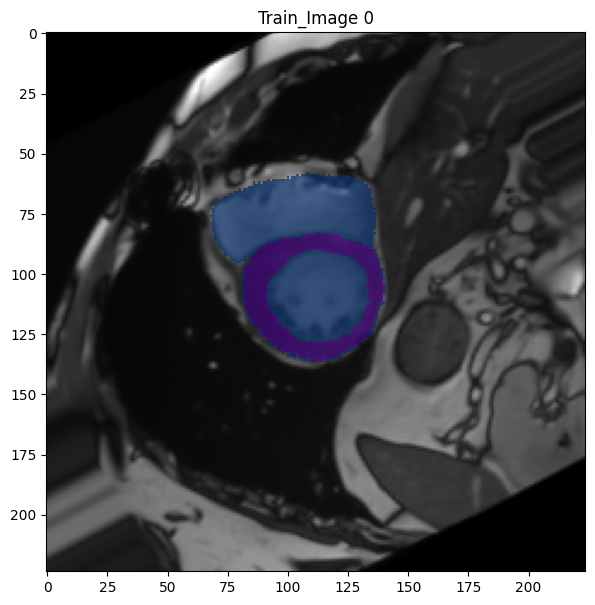

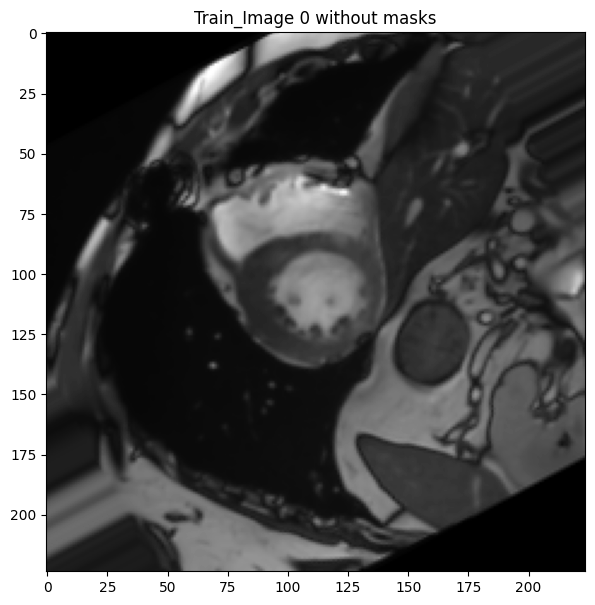

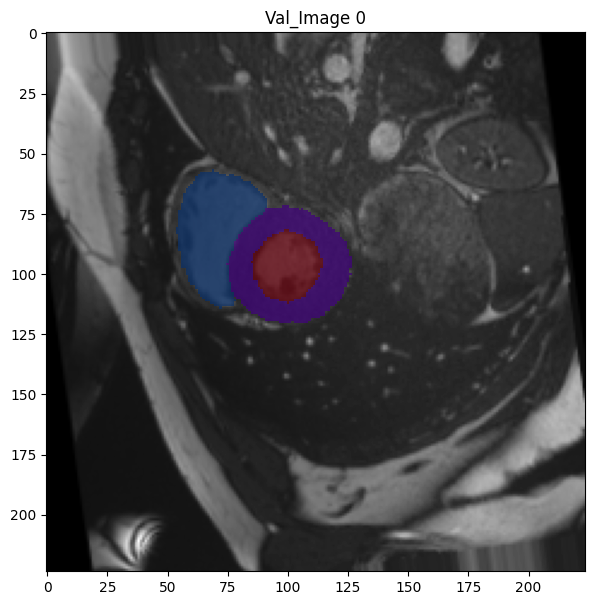

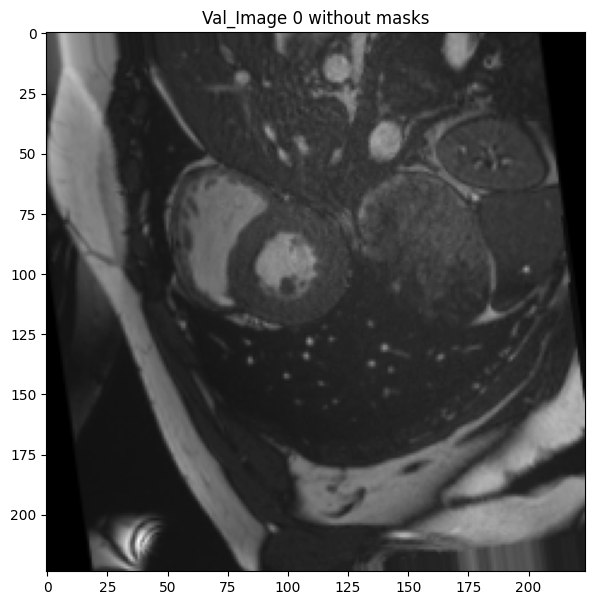

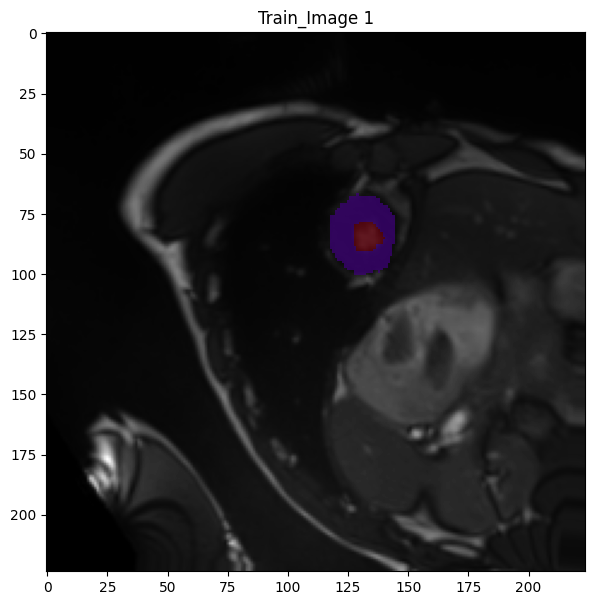

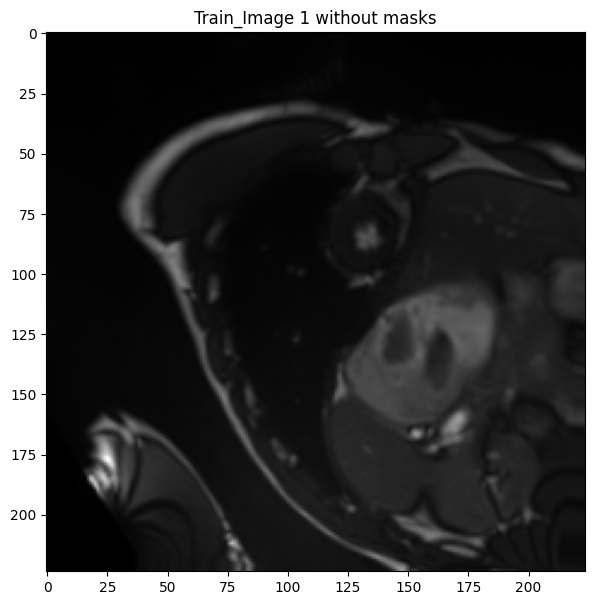

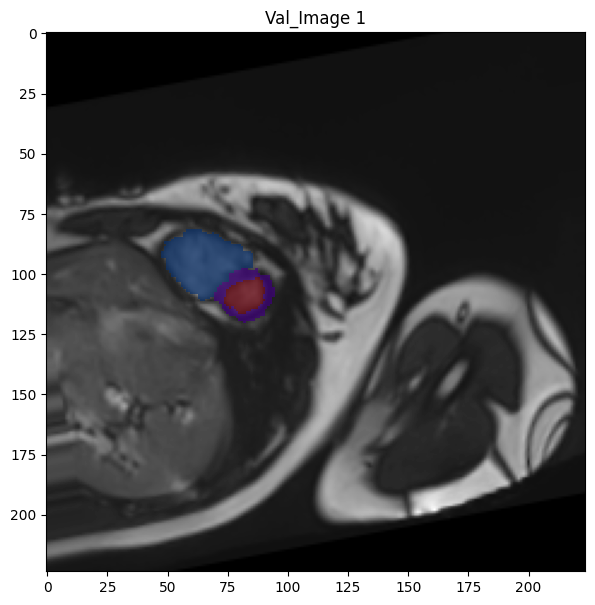

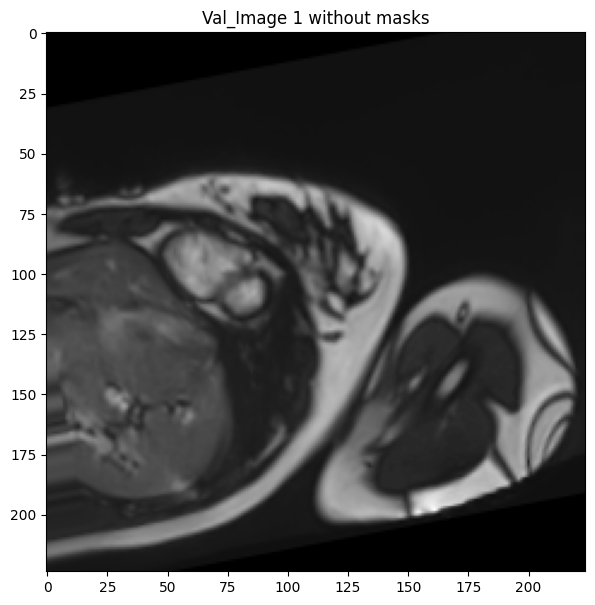

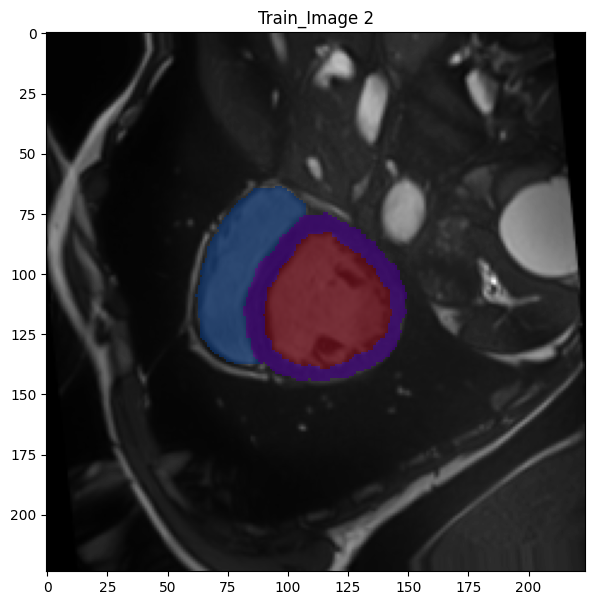

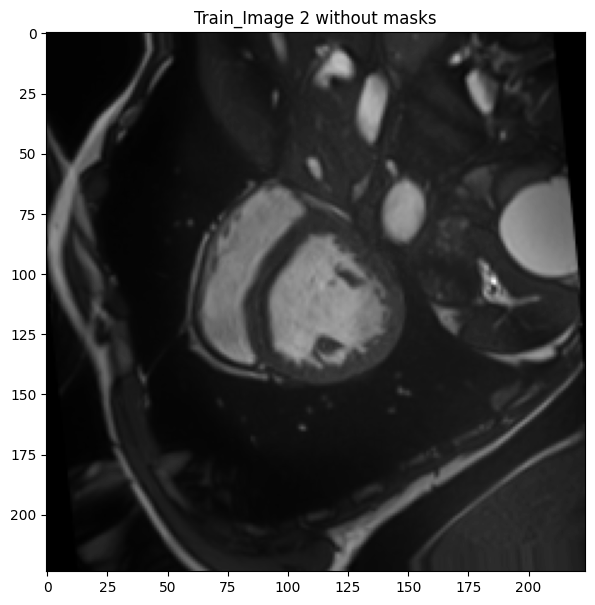

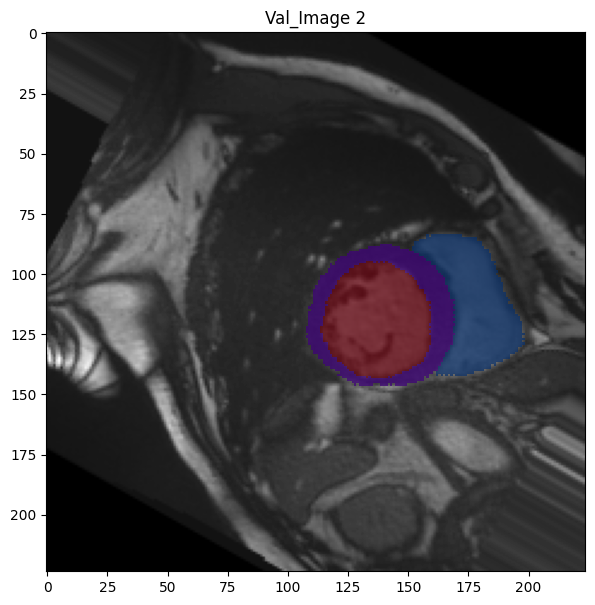

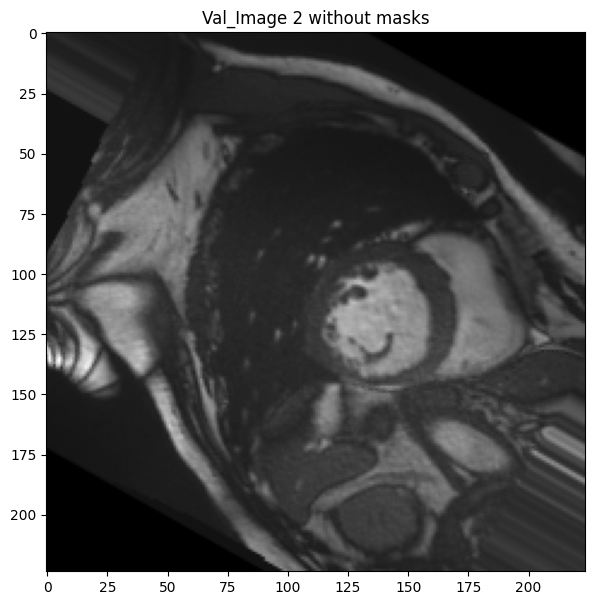

In [11]:
for i in range(3):
    index = np.random.randint(0, len(train_dataset))
    image = train_dataset[index]
    visualize_mri_sample(image, "Train_Image " + str(i))

    index = np.random.randint(0, len(val_dataset))
    image = val_dataset[index]
    visualize_mri_sample(image, "Val_Image " + str(i))

**Create a dataloader for the corresponding data.**

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

**Visualization of preprocessing impact on 'broken' masks**

In [13]:
# longMasks = []
# for batch in tqdm(train_dataloader):
#     masks = batch['mask']
#     for mask in masks:
#         if len(np.unique(mask)) > 4:
#             mask=mask[0]
#             print(np.unique(mask))
#             mask[np.logical_and(mask>170,mask<255)]=1
#             mask[np.logical_and(mask>3,mask<85)]=2
#             mask[np.logical_and(mask>85,mask<170)]=3
#             print(np.unique(mask))
#             longMasks.append(mask)
# print(longMasks[0].shape)

In [14]:
# print(type(longMasks[0]))
# for mask in longMasks:
#     plt.imshow(mask)
#     plt.show()
#     print(f'       ^^ {np.unique(mask)}')

**The selection of the correct and availble GPUs on the virtual machine.**

In [15]:
def mean(lst):
    return sum(lst) / len(lst)

In [16]:
from medpy.metric.binary import hd, dc
def metrics(img_gt, img_pred):#, voxel_size):
    """
    Function to compute the metrics between two segmentation maps given as input.
    ----------
    
    Abbreviations:
    ----------
    LV: left ventricle
    RV: right ventricle
    MYO: myocardium
    
    Parameters
    ----------
    img_gt: np.array
    Array of the ground truth segmentation map.  (LV --> class 3, RV --> class 1, myocardium --> class 2)

    img_pred: np.array
    Array of the predicted segmentation map.

    voxel_size: list, tuple or np.array
    The size of a voxel of the images used to compute the volumes (in mm).
    
    For example: for voxels of size 2mm by  1mm by 8mm, use voxel_size = np.array([2 1 8])

    Return
    ------
    A list of metrics in this order, [Dice LV, Volume LV, Err LV(ml),
    Dice RV, Volume RV, Err RV(ml), Dice MYO, Volume MYO, Err MYO(ml)]
    """

    if img_gt.ndim != img_pred.ndim:
        raise ValueError("The arrays 'img_gt' and 'img_pred' should have the "
                         "same dimension, {} against {}".format(img_gt.ndim,
                                                                img_pred.ndim))

    lv = 0
    rv = 0
    myo = 0
    dices = []
    hds = []
    # Loop on each classes of the input images
    # instead of loop through the list of 3,1,2, get np.unique of mask and loop through all but 0's
    for c in [3, 1, 2]:
        # Copy the gt image to not alterate the input
        gt_c_i = np.copy(img_gt)
        gt_c_i[gt_c_i != c] = 0

        # Copy the pred image to not alterate the input
        pred_c_i = np.copy(img_pred)
        pred_c_i[pred_c_i != c] = 0

        # Clip the value to compute the volumes
        gt_c_i = np.clip(gt_c_i, 0, 1)
        pred_c_i = np.clip(pred_c_i, 0, 1)
        
        # Compute the Dice
        dice = dc(gt_c_i, pred_c_i)
        
        # Save the dice score per class
        if c==3:
            lv = dice
        elif c==1:
            rv = dice
        elif c==2:
            myo = dice

        # Append to this list to calculate mean dice
        dices.append(dice)

        #Compute Hausdorff Distance
        hausdorf = hd(pred_c_i, gt_c_i)
        hds.append(hausdorf)
        
        # Compute volume
        volpred = pred_c_i.sum() * np.prod(voxel_size) / 1000.
        volgt = gt_c_i.sum() * np.prod(voxel_size) / 1000.

    return mean(dices), lv, rv, myo, mean(hds), volpred, volpred-volgt

In [17]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

The used device is cuda:6


**Definition of the basic U-net model based on the tutorial.**

In [107]:
# Things to tweak: Kernel size, channels, amt of layers (6 layers only made it worse),
# learning rate, strides (5*2 with 6layers was worse), num res units, batch size, transforms

model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=4,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function =  monai.losses.DiceLoss(softmax=True, batch=True, to_onehot_y=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [108]:
from tqdm import tqdm
import wandb
import datetime
# now = datetime.datetime.now() # current date and time
# nu = now.strftime('%c')

# run = wandb.init(
#     project='ACDC_Segmentation',
#     name='BasicTrans_SimpleModel_AllData_',
#     config={
#         'loss function': str(loss_function),
#         'lr': optimizer.param_groups[0]["lr"],
#         'transform': from_compose_to_list(composed_transform),
#         'batch_size': train_dataloader.batch_size,
#         'model': model,
#     }
# )
# # Do not hesitate to enrich this list of settings to be able to correctly keep track of your experiments!
# # For example you should add information on your model...

# run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """

    # Apply sigmoid to model ouput and round to nearest integer (0 or 1)
    # sigmoid = torch.nn.Sigmoid()
    # mask_output = sigmoid(mask_output)
    # mask_output = torch.round(mask_output)

    # Transform masks to numpy arrays on CPU
    # Note: .squeeze() removes all dimensions with a size of 1 (here, it makes the tensors 2-dimensional)
    # Note: .detach() removes a tensor from the computational graph to prevent gradient computation for it
    mask_output = mask_output.squeeze()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class label and insert masks
    class_labels = {1: 'left-ventricle', 2: 'right-ventricle', 3: 'myocardium'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks

def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    # Create list of images that have segmentation masks for model output and ground truth
    log_imgs = [wandb.Image(img, masks=wandb_masks(mask_output, mask_gt)) for img, mask_output,
                mask_gt in zip(batch_data['img'], outputs, batch_data['mask'])]

    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})

# ⌨️ WRITE YOUR TRAINING LOOP HERE
from tqdm import tqdm

def train_medmnist(model, train_dataloader, val_dataloader, optimizer, epochs, device, val_freq=1):
    train_loss = []
    val_loss = []
    best_dice = -1
    best_loss = 10
    
    for epoch in tqdm(range(epochs)):
        model.train()
        steps = 0
        epoch_loss = 0

        for batch in train_dataloader:
            optimizer.zero_grad()
            images = batch['img'].float().to(device)
            labels = batch['mask'].float().to(device)
            output = model(images)
            loss = loss_function(output, labels)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            steps += 1
            train_ep_loss = epoch_loss/steps
        train_loss.append(epoch_loss/steps)

        # validation loop
        if epoch % val_freq == 0:
            steps = 0
            val_epoch_loss = 0
            model.eval()
            for batch in val_dataloader:
                optimizer.zero_grad()
                images = batch['img'].float().to(device)
                labels = batch['mask'].float().to(device)
                output = model(images)
                loss = loss_function(output, labels)
                val_epoch_loss += loss.item()
                steps += 1
                val_ep_loss = val_epoch_loss/steps

                # ---------- OLD DICE SCORE -----------
                # Run images through inferer and transform for Dice score calculation
                # batch_dices = []
                # inferer = monai.inferers.SimpleInferer()
                # discrete_transform = monai.transforms.AsDiscrete(argmax = True)
                # Softmax = torch.nn.Softmax()
                # diceImages = batch['img'].float().to(device)

#                 for image in diceImages:
#                     with torch.no_grad():
#                         output = discrete_transform(Softmax(model(image).cpu())).squeeze()
#                     dice_mask = np.argmax(output, axis=0)

#                     print(f'dicemask: {np.unique(dice_mask)}, gtmask: {np.unique(labels[i])}')

#                     #Calculate mean Dice score for validation batch
#                     dice = metrics(labels[i], dice_mask)
#                     print(dice)
#                     batch_dices.append(dice)
#                 mean_dice = mean(batch_dices)

                # Save the network if its Dice score is better than the current best
                if val_ep_loss < best_loss:
                    best_loss = val_ep_loss
                    print(f'Best val loss: {best_loss}')
                    torch.save(model.state_dict(), r'ACDC_Best_Kernel5.pt')

            val_loss.append(val_ep_loss)
        # log_to_wandb(epoch, train_ep_loss, val_ep_loss, batch, output)

    return train_loss, val_loss, model

val_freq = 1
n_epochs = 150

train_loss, val_loss, model = train_medmnist(model, train_dataloader, val_dataloader, optimizer, n_epochs, device, val_freq)

torch.save(model.state_dict(), r'ACDC_Last_Kernel5.pt')
# run.finish()

  0%|          | 0/150 [00:00<?, ?it/s]

Best val loss: 0.42235666513442993


  1%|          | 1/150 [00:26<1:05:33, 26.40s/it]

Best val loss: 0.20622862875461578


  1%|▏         | 2/150 [00:51<1:03:35, 25.78s/it]

Best val loss: 0.14669057726860046


  2%|▏         | 3/150 [01:16<1:01:33, 25.12s/it]

Best val loss: 0.12483182549476624


  3%|▎         | 5/150 [02:04<59:45, 24.73s/it]  

Best val loss: 0.10427618026733398


  4%|▍         | 6/150 [02:26<57:11, 23.83s/it]

Best val loss: 0.09828391671180725


  7%|▋         | 10/150 [04:03<56:53, 24.38s/it]

Best val loss: 0.07855850458145142
Best val loss: 0.07706191390752792


 10%|█         | 15/150 [07:16<1:04:39, 28.74s/it]

Best val loss: 0.06989786028862


 13%|█▎        | 19/150 [09:01<55:54, 25.61s/it]  

Best val loss: 0.06986823678016663
Best val loss: 0.06831918656826019


 14%|█▍        | 21/150 [10:21<1:07:55, 31.60s/it]

Best val loss: 0.06334780156612396


 20%|██        | 30/150 [14:04<48:58, 24.49s/it]  

Best val loss: 0.0627424567937851


 21%|██        | 31/150 [14:28<47:51, 24.13s/it]

Best val loss: 0.059973374009132385


 30%|███       | 45/150 [19:53<40:31, 23.16s/it]

Best val loss: 0.05864010751247406


 33%|███▎      | 50/150 [21:47<37:30, 22.51s/it]

Best val loss: 0.0572853684425354


 37%|███▋      | 56/150 [24:08<36:31, 23.32s/it]

Best val loss: 0.057007573544979095


 38%|███▊      | 57/150 [24:30<35:25, 22.86s/it]

Best val loss: 0.055500730872154236


 39%|███▉      | 59/150 [25:13<33:42, 22.23s/it]

Best val loss: 0.05423454940319061


 43%|████▎     | 65/150 [27:34<33:10, 23.42s/it]

Best val loss: 0.053133994340896606


 51%|█████▏    | 77/150 [32:30<29:58, 24.63s/it]

Best val loss: 0.053018152713775635


 54%|█████▍    | 81/150 [34:07<28:01, 24.37s/it]

Best val loss: 0.05089607834815979


 67%|██████▋   | 101/150 [42:08<19:41, 24.11s/it]

Best val loss: 0.050203412771224976


 71%|███████   | 106/150 [44:08<17:37, 24.04s/it]

Best val loss: 0.04919461905956268


 73%|███████▎  | 109/150 [45:21<16:30, 24.15s/it]

Best val loss: 0.04896154999732971


 82%|████████▏ | 123/150 [50:59<10:57, 24.35s/it]

Best val loss: 0.04817505180835724


100%|██████████| 150/150 [1:01:54<00:00, 24.76s/it]


In [23]:
# Plot training and validation loss

plt.figure()
plt.plot(train_loss, label='Training loss')
plt.plot(np.linspace(0, n_epochs, int(n_epochs/val_freq)), val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'train_loss' is not defined

<Figure size 640x480 with 0 Axes>

In [24]:
def evaluation(sample, model, visual=False):
    """
    Given a model, calculate the dice score of a sample image and ground truth pair.
    Model will be used to create a predicted mask, dice score is calculated between this and ground truth.
    
    If visual=True:
    Allow the visual inspection of one sample by plotting the X-ray image, the ground truth (green)
    and the segmentation map produced by the network (red).
    
    Args:
        sample (Dict[str, torch.Tensor]): sample composed of an X-ray ('img') and a mask ('mask').
        model (torch.nn.Module): trained model to evaluate.
        visual (Boolean): True if you want to see the predicted masks visualized -> will take much longer
    """
    
    # infer output of network
    model.eval()
    inferer = monai.inferers.SimpleInferer()
    Softmax = torch.nn.Softmax()
    
    with torch.no_grad():
        output = Softmax(inferer(sample['img'].to(device), network=model).cpu()).squeeze().detach().numpy()
    classes = np.argmax(output, axis=0)  # find class with highest probabillity per pixel
    gtmask = sample['mask'].squeeze().numpy()
    dice, lv, rv, myo = metrics(gtmask, classes)
    
    
    if visual:
        print(f'For image below, dice = {dice}')
        fig, ax = plt.subplots(1,3, figsize = [12, 10])

        # mask = ground truth segmentation
        mask = np.squeeze(sample['mask'])
        mask1 = np.logical_and(np.logical_and(mask==0,mask==1),mask==2)
        mask2 = np.logical_and(np.logical_and(mask==0,mask==2),mask==3)
        mask3=  np.logical_and(np.logical_and(mask==0,mask==1),mask==3)

        # create mask for background
        overlay_mask1 = np.ma.masked_where(mask!=1, mask)
        overlay_mask2 = np.ma.masked_where(mask!=2 ,mask)
        overlay_mask3 = np.ma.masked_where(mask!=3, mask)

        # Plot MRI image
        ax[0].imshow(sample["img"].squeeze(), 'gray')
        ax[0].set_title('Grey scale MRI')

        # Plot ground truth
        ax[1].imshow(sample["img"].squeeze(), 'gray')
        ax[1].imshow(overlay_mask1, 'Reds', alpha = 0.7, clim=[0,1], interpolation='nearest')
        ax[1].imshow(overlay_mask2, 'Blues', alpha = 0.7, clim=[0,1], interpolation='nearest')
        ax[1].imshow(overlay_mask3, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
        ax[1].set_title('Ground truth')

        mask = classes  # rename (because code for ground truth was copied, and there I named them 'mask' instead of 'classes')
        # select the different components (= value 1, 2 or 3 for myo, LV and RV)
        mask1 = np.logical_and(np.logical_and(mask==0,mask==1),mask==2)
        mask2 = np.logical_and(np.logical_and(mask==0,mask==2),mask==3)
        mask3=  np.logical_and(np.logical_and(mask==0,mask==1),mask==3)

        # create mask for background
        overlay_mask1 = np.ma.masked_where(mask!=1, mask)
        overlay_mask2 = np.ma.masked_where(mask!=2 ,mask)
        overlay_mask3 = np.ma.masked_where(mask!=3, mask)  

        ax[2].imshow(sample["img"].squeeze(), 'gray')
        ax[2].imshow(overlay_mask1, 'Reds', alpha = 0.7, clim=[0,1], interpolation='nearest')
        ax[2].imshow(overlay_mask2, 'Blues', alpha = 0.7, clim=[0,1], interpolation='nearest')
        ax[2].imshow(overlay_mask3, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
        ax[2].set_title('Prediction')
        plt.show()
    
    return dice, lv, rv, myo, classes

In [25]:
secret_data_path = "./secret_preprocessed/"
if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["secret_test"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain training and testing folders).")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


In [45]:
test_dict = build_dict_ACDC(secret_data_path, mode='secret', heart_mode="secret")
print(len(test_dict))
test_transform = monai.transforms.Compose([
                                           LoadMriData(),
                                           monai.transforms.AddChanneld(keys=['img', 'mask']),
                                           monai.transforms.NormalizeIntensityd(keys=['img']),
                                           # monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']),
                                           # monai.transforms.Resized(keys = ['img','mask'],spatial_size=(1024,1024), mode=['bilinear','nearest'])
                                            ])
test_set = monai.data.CacheDataset(test_dict, transform=test_transform)
test_loader = monai.data.DataLoader(test_set, batch_size=1)

100%|██████████| 25/25 [00:00<00:00, 3031.53it/s]


282


Loading dataset:   0%|          | 0/282 [00:00<?, ?it/s]


RuntimeError: applying transform <__main__.LoadMriData object at 0x7f68b813cdc0>

In [19]:
# Dice scores of models with this architecture:
# - Best_Basic.pt: 0.6613432727090607
# - Last_Basic.pt: 0.7322..
# - Best_NewTrans: 0.7589075271760529
# - Last_NewTrans: 0.7562161966539251
# - Best_6Layers: 0.6607905967465393
# - Last_6Layers: 0.6596011656943401
# - Best_HIghLR: 0.5132312381186614
# - Last_HighLR: 0.5132307676388257
# - 32 Batch size: 0.59287373909797
# - Best_Kernel5: 0.7030439132476438
# - Last_Kernel5: 0.7308205497238879

model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=4,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load("ACDC_Last_Kernel5.pt"))
model.eval()
print("Model loaded")

Model loaded


In [20]:
dices = []
lvs = []
rvs = []
myos = []
hds = []
best_dice = 0
worst_dice = 10
switch = False
for i, sample in enumerate(tqdm(test_loader)):
    # Initialize empty masks once
    if switch == False:
        best_seg = np.array(sample.shape)
        worst_seg = np.array(sample.shape)
        switch = True
    
    # Get voxel_size from image name
    voxel_size = test_dict[i]['img'].split('_')[-1]
    
    dice, lv, rv, myo, seg, volpred, volerror = evaluation(sample, model, voxel_size)
    
    lvs.append(lv)
    rvs.append(rv)
    myos.append(myo)
    
    if dice > best_dice:
        best_seg = seg
        best_dice = dice
    elif dice < worst_dice:
        worst_seg = seg
        worst_dice = dice
    dices.append(dice)
    hds.append(hd)
    
meanlv = mean(lvs)
meanrv = mean(rvs)
meanmyo = mean(myos)
meandice = mean(dices)
meanhd = mean(hds)

print(f'Total mean Dice: {meandice}, mean Dice LV: {meanlv}, mean Dice RV: {meanrv}, mean Dice Myo: {meanmyo}, mean Hausdorff: {meanhd}')

100%|██████████| 1076/1076 [00:13<00:00, 77.84it/s]

Final validation dice: 0.7308205497238879


In [ ]:
for i, sample in enumerate(tqdm(test_loader)):
    mask = evaluation(sample, model)
    mask = np.array(mask, dtype=np.uint8)
    mask = Image.fromarray(mask)
    filename = test_dict[i]['img'][-30:]
    if test_dict[i][]


file = test_dict[i]
gt_nii = nib.load(file)
gt = gt_nii.get_fdata()